In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 94.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=ff2e3dae583746fa80538af826aa631f766f572b286d50b39155faf07f9a3f0e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
# Download Training dataset file.

import requests
URL = "https://www.dropbox.com/s/cem9ea35wllfsqg/train.csv?dl=1"
response = requests.get(URL)
open("train.csv", "wb").write(response.content)

200589097

In [ ]:
# Download Testing dataset file.

URL = "https://www.dropbox.com/s/hrqzwaihgeibx4x/test.csv?dl=1"
response = requests.get(URL)
open("test.csv", "wb").write(response.content)

70794289

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from math import radians, cos, sin, asin, sqrt
from pyspark.sql.types import FloatType

spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()
df = spark.read.csv("./train.csv", header=True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)



In [ ]:
df.show()

+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+-------------------+------------------+-------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.982154846191406|40.767936706542969|-73.964630126953125|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.980415344238281|40.738563537597656|-73.999481201171875|40.731151580810547|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:

In [ ]:
# Check for NaN or null values

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
| id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



In [ ]:
# Removing id from `id` column.

df = df.withColumn("id", expr("replace(id, 'id', '')"))

In [ ]:
# Covert Datatype of the dataframe.

def convert_datatype(df):
    df = df.withColumn("id",df.id.cast('int'))
    df = df.withColumn("vendor_id", df.vendor_id.cast('int'))
    df = df.withColumn("pickup_datetime", to_timestamp(df.pickup_datetime, "yyyy-MM-dd HH:mm:ss"))
    df = df.withColumn("dropoff_datetime", to_timestamp(df.dropoff_datetime, "yyyy-MM-dd HH:mm:ss"))
    df = df.withColumn("passenger_count",df.passenger_count.cast('int'))
    df = df.withColumn("pickup_longitude",df.pickup_longitude.cast('double'))
    df = df.withColumn("pickup_latitude",df.pickup_latitude.cast('double'))
    df = df.withColumn("dropoff_longitude",df.dropoff_longitude.cast('double'))
    df = df.withColumn("dropoff_latitude",df.dropoff_latitude.cast('double'))
    df = df.withColumn('store_and_fwd_flag', F.when(df.store_and_fwd_flag == 'N', 0).otherwise(1))
    df = df.withColumn("trip_duration",df.trip_duration.cast('int'))
    
    return df

In [ ]:
# Call Convert datatype

df = convert_datatype(df)

In [ ]:
# Check for columns data types

for col in df.dtypes:
    print(col[0]+" , "+col[1])

id , int
vendor_id , int
pickup_datetime , timestamp
dropoff_datetime , timestamp
passenger_count , int
pickup_longitude , double
pickup_latitude , double
dropoff_longitude , double
dropoff_latitude , double
store_and_fwd_flag , int
trip_duration , int


In [ ]:
# Calculate difference in dropoff and pickup time

df = df.withColumn('diff_in_dropff_and_pickup',df["dropoff_datetime"].cast("double") - df['pickup_datetime'].cast("double"))

In [ ]:
# Calculate the difference between trip duration and the difference of the pickup and dropoff time

df = df.withColumn('diff_in_trip_duration_and_manual_calc_time',df["trip_duration"].cast("double") - df['diff_in_dropff_and_pickup'].cast("double"))

In [ ]:
# Checking for unique values in `diff_in_trip_duration_and_manual_calc_time`

df.select('diff_in_trip_duration_and_manual_calc_time').distinct().collect()

[Row(diff_in_trip_duration_and_manual_calc_time=0.0)]

In [ ]:
# Checking if trip duration is 0 or negative, if there then we can remove it.

df.filter(df.trip_duration <= 0).count()

0

In [ ]:
# Checking for unique values in `store_and_fwd_flag`

df.select('store_and_fwd_flag').distinct().collect()

[Row(store_and_fwd_flag=1), Row(store_and_fwd_flag=0)]

In [ ]:
# Calculate distance between two latitute and longtitude.

def distance(pickUpLat1, dropOffLat2, pickUpLon1, dropOffLon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(pickUpLon1)
    lon2 = radians(dropOffLon2)
    lat1 = radians(pickUpLat1)
    lat2 = radians(dropOffLat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [ ]:
# Calculating distance between pickup and dropoff latitude and longtitude.

udf_func = udf(distance, FloatType())
df = df.withColumn("distance", udf_func(df.pickup_latitude, df.dropoff_latitude, df.pickup_longitude, df.dropoff_longitude))

In [ ]:
# distance is in K.M.

df.select("distance").show()

+----------+
|  distance|
+----------+
| 1.4985207|
| 1.8055072|
| 6.3850985|
| 1.4854984|
| 1.1885885|
| 1.0989425|
| 1.3262786|
| 5.7149806|
| 1.3103533|
| 5.1211615|
| 3.8061395|
| 3.7730958|
|  1.859483|
|0.99168485|
|  6.382836|
|  0.656578|
|  3.428086|
| 2.5386717|
| 4.6052012|
| 1.3032712|
+----------+
only showing top 20 rows



In [ ]:
# Only keep records where distance between non overlapped points

print("Count unique values Before filtering for distance < 0 is ", df.count()) 
df = df.filter(df.distance > 0)

Count unique values Before filtering for distance < 0 is  1458644


In [ ]:
# Counting total number of unique values in dataframe.

df.count()

1452747

In [ ]:
######################################################################################################################

In [ ]:
print(df.columns)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'diff_in_dropff_and_pickup', 'diff_in_trip_duration_and_manual_calc_time', 'distance']


In [ ]:
# Remove all trips that have trip_duration more than 50000 seconds which is equivalent to more than 14 hours and less than 10 seconds.
# Remove all trips which total distance is less than 0.5 and more than 200 KM because NYC is not big than 200 KM.

df_trip_duration_filter = df.filter(df.trip_duration < 50000)
df_trip_duration_filter = df_trip_duration_filter.filter(df_trip_duration_filter.trip_duration > 10)

df_lr = df_trip_duration_filter.filter(df_trip_duration_filter.distance > 0.5)
df_lr = df_lr.filter(df_lr.distance < 200)

print(df_lr.count())


1407802


In [ ]:
# Use the pickup datetime column to get hour of the day, day of the week, year, month, and hour

from pyspark.sql.functions import col
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

df_lr = df_lr.withColumn('day_week', date_format(col("pickup_datetime"), "u"))
df_lr = df_lr.withColumn('year', date_format(col("pickup_datetime"), "y"))
df_lr = df_lr.withColumn('month', date_format(col("pickup_datetime"), "M"))
df_lr = df_lr.withColumn('hour', date_format(col("pickup_datetime"), "H"))

df_lr = df_lr.withColumn("day_week",col("day_week").cast("int"))
df = df_lr.withColumn("year",col("year").cast("int"))
df_lr = df_lr.withColumn("month",col("month").cast("int"))
df_lr = df_lr.withColumn("hour",col("hour").cast("int"))


X = df_lr.select(col('day_week'), col('year'), col('month'), col('hour'), col('pickup_latitude'), col('pickup_longitude'),col('dropoff_latitude'), col('dropoff_longitude'), col('distance')).toPandas()

In [ ]:
# Use StandardScaler to set all the columns in the dataframe to the same scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()                   # Scale the input values
scaled_X = scaler.fit_transform(X)

# Print out some rows of the scaled dataframe
for i in range(5):
    print(scaled_X[i])

[-1.56029207  0.         -0.30778988  0.52792827  0.60094999 -0.2239432
  0.42098501  0.23926327 -0.51463576]
[ 1.50968341  0.          1.47715721 -2.12771385 -0.43565428 -0.17886549
 -0.63163494 -0.70942905 -0.43746736]
[-1.04862949  0.         -1.49775461 -0.40935719  0.45986411 -0.14288241
 -1.27525884 -0.86872131  0.71372271]
[-0.53696691  0.          0.28719248  0.84035675 -1.09181132 -0.94657053
 -1.37817805 -1.05750443 -0.51790923]
[ 0.99802083  0.         -0.30778988 -0.0969287   1.49283354  0.01192394
  0.93791221  0.01351271 -0.59254466]


k=1 done
k=2 done
k=3 done
k=4 done
k=5 done
k=6 done
k=7 done
k=8 done
k=9 done
k=10 done


<Figure size 800x600 with 0 Axes>

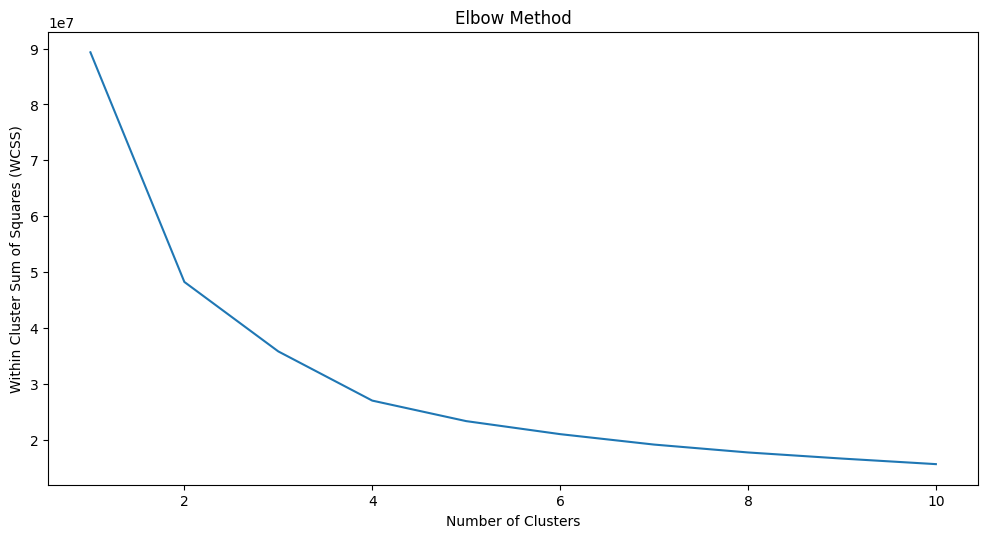

In [ ]:
# Determine the optimal number of clusters using the Elbow Method
# For more info on elbow method: https://towardsdatascience.com/clustering-using-k-means-with-implementation-40988620a973
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=100)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    print('k='+str(i)+ ' done')

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.show()

In [ ]:
# We can see that the graph above levels off at around k=5. So we will use that as our number of clusters
# Now we will create a k-means clustering model that uses 5 clusters (k=5)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(scaled_X)

cluster
0    368608
1    492122
2    495048
3     52024
Name: cluster, dtype: int64


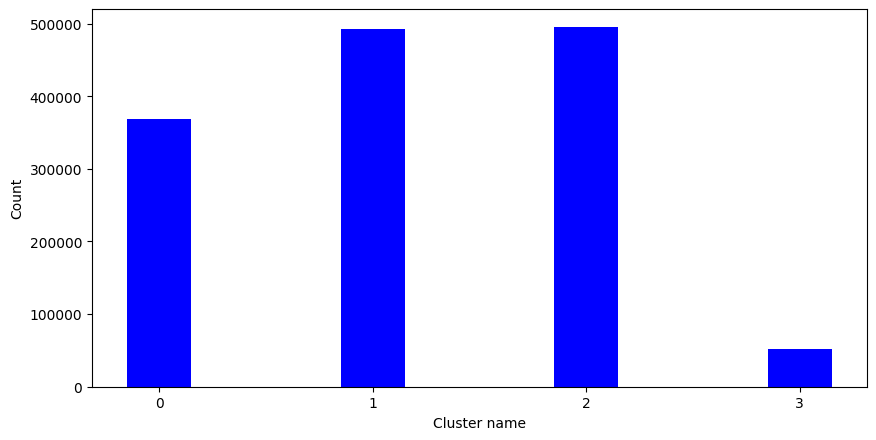

In [ ]:
# Graph out the size of each cluster

X['cluster'] = clusters
cluster_counts = X.groupby(['cluster'])['cluster'].count()

print(cluster_counts.head())

plt.figure(figsize=(10, 5), dpi=100)
plt.bar(['0', '1', '2', '3'], cluster_counts.values, color='blue', width = 0.3)
plt.xlabel('Cluster name')
plt.ylabel('Count')
plt.show()

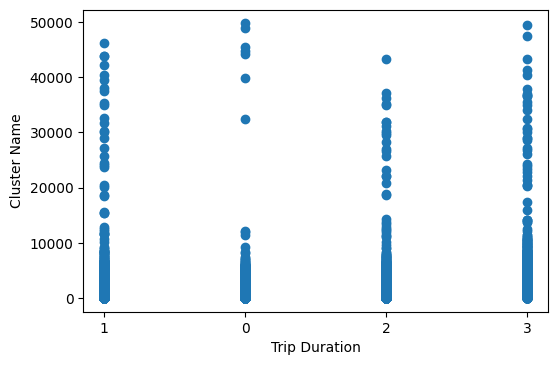

In [ ]:
import numpy as np

plt.figure(figsize=(6, 4), dpi=100)
plt.scatter(X['cluster'].astype(str), df_lr.select('trip_duration').toPandas()['trip_duration'])
plt.xlabel('Trip Duration')
plt.ylabel('Cluster Name')
plt.show()

